In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import datetime
from datetime import datetime,time,timedelta
import time

In [3]:
import csv
import os

In [4]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import classification_report

In [6]:
import plotly.express as px

In [7]:
import random

In [8]:
userID ='42df9b2a-4100-4bf2-83e2-45cd93e5a123'
#'46429a60-2178-4b04-90d4-614172f338fe' 
#'42df9b2a-4100-4bf2-83e2-45cd93e5a123'      

## ANOVA test on Dailies Summaries 

### Creation of dailies dataframe 

In [9]:
dailies=pd.read_csv(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\DataFrames\Dailies_df.csv')

#removing duplicates
dailies=dailies.drop_duplicates(keep='first')
dailies=dailies.reset_index(drop=True)

for i in range(0,len(dailies)):
    dailies['calendarDate'][i]=pd.to_datetime(dailies['calendarDate'][i]).strftime('%d-%m-%Y')


C:\Users\cbelb\AppData\Local\Temp\ipykernel_14292\1129399113.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dailies['calendarDate'][i]=pd.to_datetime(dailies['calendarDate'][i]).strftime('%d-%m-%Y')


### Dailies division according to weeks 

In [10]:
#NOTE: variable calendarDate need to be transformed into a categorical variable, in order to correctly perform ANOVA test

weeks=[]
counter=1

for i in range(0,len(dailies),7):
    weeks.append(dailies.loc[i:i+6])
    dailies['calendarDate'][i:i+7]=counter
    counter+=1
    
print(len(weeks))

36


C:\Users\cbelb\AppData\Local\Temp\ipykernel_14292\3163691272.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dailies['calendarDate'][i:i+7]=counter


### Removing NaN values

In [11]:
#removing columns with all NaN values
dailies.dropna(axis=1,how='all',inplace=True)

#heart rate standard deviation: varialbe to be added in dailies dataframe
HR_std=dailies.loc[:,'timeOffsetHeartRateSamples.15':'timeOffsetHeartRateSamples.35340'].std(axis=1)

#removing variables not useful in anova test
dailies=dailies.loc[:,:'floorsClimbedGoal'].drop(columns='stressQualifier')
dailies.drop(columns=['startTimeInSeconds', 'durationInSeconds', 'intensityDurationGoalInSeconds', 'floorsClimbedGoal','stepsGoal'],inplace=True)

dailies['HR_std']=HR_std

#removing rows with Nan values and reindexing 
dailies.dropna(axis=0, inplace=True)
dailies.reset_index(drop=True, inplace=True)

### ONE-way ANOVA test

In [12]:
aov_variables=dailies.columns[1:]
p_values=[]

for i in range(0,len(aov_variables)):
    model=smf.ols(formula='{} ~ C(calendarDate) '.format(aov_variables[i]), data=dailies).fit()
    #model.summary()
    aovTable=sm.stats.anova_lm(model,typ=1)
    p_values.append(aovTable.iloc[0,-1])

aov_summary={'Dailies Variables': aov_variables, 'P values':p_values}
aov_summary=pd.DataFrame(aov_summary)

aov_summary=aov_summary[aov_summary['P values']<=0.05]
aov_summary.reset_index(drop=True,inplace=True)
aov_summary

,Dailies Variables,P values
0,steps,2.104369e-02
1,distanceInMeters,3.461326e-02
2,activeTimeInSeconds,7.952907e-03
3,activeKilocalories,3.646152e-04
4,floorsClimbed,4.434692e-02
5,minHeartRateInBeatsPerMinute,6.391360e-06
6,averageHeartRateInBeatsPerMinute,1.358599e-15
7,maxHeartRateInBeatsPerMinute,5.134149e-03
8,restingHeartRateInBeatsPerMinute,7.808630e-04
9,averageStressLevel,2.127538e-09


In [13]:
#saving data
if os.path.exists(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\DailiesFS') == False:
    os.makedirs(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\DailiesFS')  
    
if os.path.exists(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\DailiesFS\ANOVA.xlsx') == True:
    os.remove(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\DailiesFS\ANOVA.xlsx')

aov_summary.to_excel(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\DailiesFS\ANOVA.xlsx')

### TukeyHSD multiple comparison

In [14]:
tables=[]
tuk_variables=aov_summary['Dailies Variables'] #taking only those variables for which ANOVA test gave p<=0.05


for i in range(0,len(tuk_variables)):
    tukeyTable = pairwise_tukeyhsd(endog=dailies[tuk_variables[i]], groups=dailies['calendarDate'], alpha=0.05)
    tukey_summary=pd.DataFrame(data=tukeyTable._results_table.data[1:],columns=tukeyTable._results_table.data[0])
    #tukey_summary
    
    tukey_summary=tukey_summary[tukey_summary['reject']==True]
    tukey_summary.rename(columns={'group1': str(tuk_variables[i])}, inplace=True)
    tukey_summary.rename(columns={'group2': str(tuk_variables[i])}, inplace=True)
    
    if tukey_summary.shape[0] != 0:
        tables.append(tukey_summary)

In [15]:
#saving data
for i in range(0,len(tables)):
    
    if os.path.exists(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\DailiesFS\\' + str(tables[i].columns[0])) == False:
        os.makedirs(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\DailiesFS\\' + str(tables[i].columns[0]))
   
    if os.path.exists(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\DailiesFS\\' + str(tables[i].columns[0])+ '\TukeyHSD.xlsx') == True:
        os.remove(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\DailiesFS\\' + str(tables[i].columns[0])+ '\TukeyHSD.xlsx')

    tables[i].to_excel(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\DailiesFS\\' + str(tables[i].columns[0])+ '\TukeyHSD.xlsx')

In [16]:
# # plotting the results provided by Tukey test is table form
# for i in range(0,len(tables)):
    
#     fig, ax = plt.subplots()

#     # hide axes
#     fig.patch.set_visible(False)
#     ax.axis('off')
#     ax.axis('tight')

#     t=ax.table(cellText=tables[i].values, colLabels=tables[i].columns, loc='center',rowLoc='center',colLoc='left',cellLoc='center')
#     t.auto_set_font_size(False)
#     t.set_fontsize(8)

#     fig.tight_layout()
#     plt.rcParams["figure.figsize"] = [8, 4];
#     plt.show()

In [17]:
#creation of a list containing the significative variables that shows significant differences through the weeks
dailies_variables=[]
for i in range(0,len(tables)):
    dailies_variables.append(tables[i].columns[0])

dailies_variables

['steps',
 'distanceInMeters',
 'activeTimeInSeconds',
 'activeKilocalories',
 'minHeartRateInBeatsPerMinute',
 'averageHeartRateInBeatsPerMinute',
 'maxHeartRateInBeatsPerMinute',
 'restingHeartRateInBeatsPerMinute',
 'averageStressLevel',
 'stressDurationInSeconds',
 'restStressDurationInSeconds',
 'lowStressDurationInSeconds',
 'mediumStressDurationInSeconds',
 'highStressDurationInSeconds']

## ANOVA test on Stress summaries

### Creation of stress dataframe

In [103]:
stress=pd.read_csv(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\DataFrames\Stress_df.csv')

#ho notato che in dailies_df ci sono deille righe che sono state duplicate 
stress=stress.drop_duplicates(keep='first')
stress=stress.reset_index(drop=True)

for i in range(0,len(stress)):
    stress['calendarDate'][i]=pd.to_datetime(stress['calendarDate'][i]).strftime('%d-%m-%Y')

#A value of -1 means there was not enough data to detect stress, and -2 means there was too much motion
StressLevelValues = stress.loc[:, 'timeOffsetStressLevelValues.0':'timeOffsetStressLevelValues.86220'] .replace(-1, np.NaN).replace(-2, np.NaN)
BodyBatteryValues = stress.loc[:, 'timeOffsetBodyBatteryValues.0':'timeOffsetBodyBatteryValues.35100']

#selecting a subset of variables useful for ANOVA test
stress=stress.loc[:,'calendarDate':'durationInSeconds']

#creating new variables 
stress['max_StressLevelValues'] = StressLevelValues.max(axis=1)
stress['min_StressLevelValues'] = StressLevelValues.min(axis=1)
stress['mean_StressLevelValues'] = StressLevelValues.mean(axis=1)
stress['std_StressLevelValues'] = StressLevelValues.std(axis=1)

stress['max_BodyBatteryValues'] = BodyBatteryValues.max(axis=1)
stress['min_BodyBatteryValues'] = BodyBatteryValues.min(axis=1)
stress['mean_BodyBatteryValues'] = BodyBatteryValues.mean(axis=1)
stress['std_BodyBatteryValues'] = BodyBatteryValues.std(axis=1)


C:\Users\cbelb\AppData\Local\Temp\ipykernel_14292\3105737454.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stress['calendarDate'][i]=pd.to_datetime(stress['calendarDate'][i]).strftime('%d-%m-%Y')


### Stress division according to weeks

In [104]:
weeks=[]
counter=1

for i in range(0,len(stress),7):
    weeks.append(stress.loc[i:i+6])
    stress['calendarDate'][i:i+7]=counter
    counter+=1
    
print(len(weeks))

36


C:\Users\cbelb\AppData\Local\Temp\ipykernel_14292\3468042938.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stress['calendarDate'][i:i+7]=counter


### Removing NaN values

In [105]:
#removing Nan values 
stress.dropna(axis=0,inplace=True)
stress=stress.reset_index(drop=True)

### ONE-way ANOVA test

In [106]:
aov_variables=stress.columns
p_values=[]

for i in range(2,len(aov_variables)):
    model=smf.ols(formula='{} ~ C(calendarDate) '.format(aov_variables[i]), data=stress).fit()
    #model.summary()
    aovTable=sm.stats.anova_lm(model,typ=1)
    p_values.append(aovTable.iloc[0,-1])

aov_summary={'Stress Variables': aov_variables[2:], 'P values':p_values}
aov_summary=pd.DataFrame(aov_summary)

aov_summary=aov_summary[aov_summary['P values']<=0.05]
aov_summary.reset_index(drop=True,inplace=True)
aov_summary

,Stress Variables,P values
0,max_StressLevelValues,5.681785e-03
1,min_StressLevelValues,4.854327e-03
2,mean_StressLevelValues,1.079320e-05
3,std_StressLevelValues,4.320684e-04
4,max_BodyBatteryValues,9.461452e-06
5,min_BodyBatteryValues,5.892773e-09
6,mean_BodyBatteryValues,1.208716e-03
7,std_BodyBatteryValues,1.667809e-11


In [107]:
#saving data
if os.path.exists(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\StressFS') == False:
    os.makedirs(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\StressFS')  
    
if os.path.exists(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\StressFS\ANOVA.xlsx') == True:
    os.remove(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\StressFS\ANOVA.xlsx')

aov_summary.to_excel(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\StressFS\ANOVA.xlsx')

### TukeyHSD multiple comparison

In [92]:
tables=[]
tuk_variables=aov_summary['Stress Variables'] 


for i in range(0,len(tuk_variables)):
    tukeyTable = pairwise_tukeyhsd(endog=stress[tuk_variables[i]], groups=stress['calendarDate'], alpha=0.05)
    tukey_summary=pd.DataFrame(data=tukeyTable._results_table.data[1:],columns=tukeyTable._results_table.data[0])
    #tukey_summary
    
    tukey_summary=tukey_summary[tukey_summary['reject']==True]
    tukey_summary.rename(columns={'group1': str(tuk_variables[i])}, inplace=True)
    tukey_summary.rename(columns={'group2': str(tuk_variables[i])}, inplace=True)

    if tukey_summary.shape[0] != 0:
        tables.append(tukey_summary)

In [93]:
#saving data
for i in range(0,len(tables)):
    
    if os.path.exists(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\StressFS\\' + str(tables[i].columns[0])) == False:
        os.makedirs(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\StressFS\\' + str(tables[i].columns[0]))
   
    if os.path.exists(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\StressFS\\' + str(tables[i].columns[0])+ '\TukeyHSD.xlsx') == True:
        os.remove(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\StressFS\\' + str(tables[i].columns[0])+ '\TukeyHSD.xlsx')

    tables[i].to_excel(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\StressFS\\' + str(tables[i].columns[0])+ '\TukeyHSD.xlsx')

In [94]:
# for i in range(0,len(tables)):
    
#     fig, ax = plt.subplots()

#     # hide axes
#     fig.patch.set_visible(False)
#     ax.axis('off')
#     ax.axis('tight')

#     t=ax.table(cellText=tables[i].values, colLabels=tables[i].columns, loc='center',rowLoc='center',colLoc='left',cellLoc='center')
#     t.auto_set_font_size(False)
#     t.set_fontsize(8)

#     fig.tight_layout()
#     plt.rcParams["figure.figsize"] = [8, 6];
#     plt.show()

In [95]:
#creation of a list containing the significative variables that shows significant differences through the weeks
stress_variables=[]
for i in range(0,len(tables)):
    stress_variables.append(tables[i].columns[0])

stress_variables

['max_StressLevelValues',
 'std_StressLevelValues',
 'max_BodyBatteryValues',
 'min_BodyBatteryValues',
 'mean_BodyBatteryValues',
 'std_BodyBatteryValues']

In [100]:
stress.loc[50:55,:]

,calendarDate,startTimeInSeconds,durationInSeconds,max_StressLevelValues,min_StressLevelValues,mean_StressLevelValues,std_StressLevelValues,max_BodyBatteryValues,min_BodyBatteryValues,mean_BodyBatteryValues,std_BodyBatteryValues
50,8,1653775200,77640,83.0,2.0,24.933555,21.031141,100.0,41.0,77.051020,20.112184
51,8,1653775200,86400,83.0,2.0,25.461300,20.553541,100.0,41.0,77.051020,20.112184
52,8,1653861600,86400,76.0,1.0,21.591667,20.414736,100.0,46.0,78.984694,17.130114
54,8,1654034400,86400,98.0,1.0,28.237654,24.044895,100.0,55.0,86.494898,14.286266
55,8,1654120800,86400,83.0,2.0,26.689320,18.039475,89.0,36.0,67.357143,14.069243


## ANOVA test on Sleep summaries

### Creation of sleep dataframe

In [27]:
sleeps=pd.read_csv(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\DataFrames\Sleeps_df.csv')

sleeps=sleeps.drop_duplicates(keep='first').reset_index(drop=True)
sleeps.reset_index(drop=True,inplace=True)

for i in range(0,len(sleeps)):
    sleeps['calendarDate'][i]=pd.to_datetime(sleeps['calendarDate'][i]).strftime('%d-%m-%Y')

sleeps=sleeps.loc[:,'calendarDate':'awakeDurationInSeconds']
sleeps.drop(columns=['startTimeInSeconds','unmeasurableSleepInSeconds'],inplace=True)


C:\Users\cbelb\AppData\Local\Temp\ipykernel_14292\67030464.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sleeps['calendarDate'][i]=pd.to_datetime(sleeps['calendarDate'][i]).strftime('%d-%m-%Y')


### Sleep division according to weeks

In [28]:
weeks=[]
counter=1

for i in range(0,len(sleeps),7):
    weeks.append(sleeps.loc[i:i+6])
    sleeps['calendarDate'][i:i+7]=counter
    counter+=1
    
print(len(weeks))

9


C:\Users\cbelb\AppData\Local\Temp\ipykernel_14292\2912562329.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sleeps['calendarDate'][i:i+7]=counter


### Removing NaN values

In [29]:
sleeps.dropna(axis=1,how='all',inplace=True)

sleeps.dropna(axis=0,inplace=True)
sleeps.reset_index(drop=True,inplace=True)

### ONE-way ANOVA test

In [30]:
aov_variables=sleeps.columns
p_values=[]

for i in range(2,len(aov_variables)):
    model=smf.ols(formula='{} ~ C(calendarDate) '.format(aov_variables[i]), data=sleeps).fit()
    #model.summary()
    aovTable=sm.stats.anova_lm(model,typ=1)
    p_values.append(aovTable.iloc[0,-1])

aov_summary={'Sleep Variables': aov_variables[2:], 'P values':p_values}
aov_summary=pd.DataFrame(aov_summary)

aov_summary=aov_summary[aov_summary['P values']<=0.05]
aov_summary.reset_index(drop=True,inplace=True)
aov_summary


,Sleep Variables,P values
0,deepSleepDurationInSeconds,0.034281
1,remSleepInSeconds,0.002039


In [31]:
#saving data
if os.path.exists(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\SleepsFS') == False:
    os.makedirs(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\SleepsFS')  
    
if os.path.exists(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\SleepsFS\ANOVA.xlsx') == True:
    os.remove(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\SleepsFS\ANOVA.xlsx')

aov_summary.to_excel(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\SleepsFS\ANOVA.xlsx')

### Tukey multiple comparison 

In [32]:
tables=[]
tuk_variables=aov_summary['Sleep Variables'] 


for i in range(0,len(tuk_variables)):
    tukeyTable = pairwise_tukeyhsd(endog=sleeps[tuk_variables[i]], groups=sleeps['calendarDate'], alpha=0.05)
    tukey_summary=pd.DataFrame(data=tukeyTable._results_table.data[1:],columns=tukeyTable._results_table.data[0])
    #tukey_summary
    
    tukey_summary=tukey_summary[tukey_summary['reject']==True]
    tukey_summary.rename(columns={'group1': str(tuk_variables[i])}, inplace=True)
    tukey_summary.rename(columns={'group2': str(tuk_variables[i])}, inplace=True)
    
    if tukey_summary.shape[0] != 0:
        tables.append(tukey_summary)

In [33]:
#saving data
for i in range(0,len(tables)):
    
    if os.path.exists(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\SleepsFS\\' + str(tables[i].columns[0])) == False:
        os.makedirs(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\SleepsFS\\' + str(tables[i].columns[0]))
   
    if os.path.exists(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\SleepsFS\\' + str(tables[i].columns[0])+ '\TukeyHSD.xlsx') == True:
        os.remove(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\SleepsFS\\' + str(tables[i].columns[0])+ '\TukeyHSD.xlsx')

    tables[i].to_excel(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\SleepsFS\\' + str(tables[i].columns[0])+ '\TukeyHSD.xlsx')

In [34]:
# for i in range(0,len(tables)):
    
#     fig, ax = plt.subplots()

#     # hide axes
#     fig.patch.set_visible(False)
#     ax.axis('off')
#     ax.axis('tight')

#     t=ax.table(cellText=tables[i].values, colLabels=tables[i].columns, loc='center',rowLoc='center',colLoc='left',cellLoc='center')
#     t.auto_set_font_size(False)
#     t.set_fontsize(8)

#     fig.tight_layout()
#     plt.rcParams["figure.figsize"] = [10, 8];
#     plt.show()

In [35]:
#creation of a list containing the significative variables that shows significant differences through the weeks
sleeps_variables=[]
for i in range(0,len(tables)):
    sleeps_variables.append(tables[i].columns[0])

sleeps_variables

['remSleepInSeconds']

## Kmeans clustering

In [36]:
#number of clusters desired
num_cl=3

### Creation of actual and test dataframe

In [75]:
# actual dataframe 
#features_actual=pd.concat([dailies[dailies_variables],stress[stress_variables], sleeps[sleeps_variables]], axis=1)
features_actual=pd.concat([dailies[dailies_variables],stress[stress_variables]], axis=1)
features_actual.dropna(inplace=True)
features_actual.reset_index(drop=True)

#test dataframe
features_test=features_actual.copy(deep=True)

#creation of list containing the weeks for actual dataframe
features_actual['weeks']=pd.Series(np.zeros(len(features_actual)),dtype=int)
counter=1

for i in range(0,len(features_actual),7):
    features_actual['weeks'][i:i+7]=counter
    counter+=1

print('Number of weeks: ', counter)

#creation of cluster_actual
features_actual['cluster']=pd.Series(np.zeros(len(features_actual)),dtype=int)

# if num_cl==2:
#     step=int(round(counter/2,ndigits=0))
#     for i in range(0,len(features_actual)):
#         if features_actual['weeks'][i] < step:
#             features_actual['cluster'][i]=0
#         else:
#             features_actual['cluster'][i]=1

# if num_cl==3:
#     step=round(counter/3,ndigits=0)
#     for i in range(0,len(features_actual)):
#         if features_actual['weeks'][i] < step:
#             features_actual['cluster'][i]=0
#         elif features_actual['weeks'][i] >=step and features_actual['weeks'][i]<step*2:
#             features_actual['cluster'][i]=1
#         else:
#             features_actual['cluster'][i]=2

# weeks=features_actual['weeks']

# #dropping the weeks column on actual dataframe
# features_actual.drop(columns='weeks',inplace=True)

Number of weeks:  32


In [86]:
stress[stress_variables].loc[51,:]

max_StressLevelValues      83.000000
std_StressLevelValues      20.553541
max_BodyBatteryValues     100.000000
min_BodyBatteryValues      41.000000
mean_BodyBatteryValues     77.051020
std_BodyBatteryValues      20.112184
Name: 51, dtype: float64

In [177]:
features_actual.columns

Index(['steps', 'distanceInMeters', 'activeTimeInSeconds',
       'activeKilocalories', 'minHeartRateInBeatsPerMinute',
       'averageHeartRateInBeatsPerMinute', 'maxHeartRateInBeatsPerMinute',
       'restingHeartRateInBeatsPerMinute', 'averageStressLevel',
       'stressDurationInSeconds', 'restStressDurationInSeconds',
       'lowStressDurationInSeconds', 'mediumStressDurationInSeconds',
       'highStressDurationInSeconds', 'max_StressLevelValues',
       'std_StressLevelValues', 'max_BodyBatteryValues',
       'min_BodyBatteryValues', 'mean_BodyBatteryValues',
       'std_BodyBatteryValues'],
      dtype='object')

In [178]:
features_test.columns

Index(['steps', 'distanceInMeters', 'activeTimeInSeconds',
       'activeKilocalories', 'minHeartRateInBeatsPerMinute',
       'averageHeartRateInBeatsPerMinute', 'maxHeartRateInBeatsPerMinute',
       'restingHeartRateInBeatsPerMinute', 'averageStressLevel',
       'stressDurationInSeconds', 'restStressDurationInSeconds',
       'lowStressDurationInSeconds', 'mediumStressDurationInSeconds',
       'highStressDurationInSeconds', 'max_StressLevelValues',
       'std_StressLevelValues', 'max_BodyBatteryValues',
       'min_BodyBatteryValues', 'mean_BodyBatteryValues',
       'std_BodyBatteryValues'],
      dtype='object')

In [124]:
len(features_actual) == len(features_test)

True

### Investigative PCA

In [125]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_test)

Explained Variance % with 2 PC:  52.8408406640403
Explained Variance % with 3 PC:  66.06752069630095


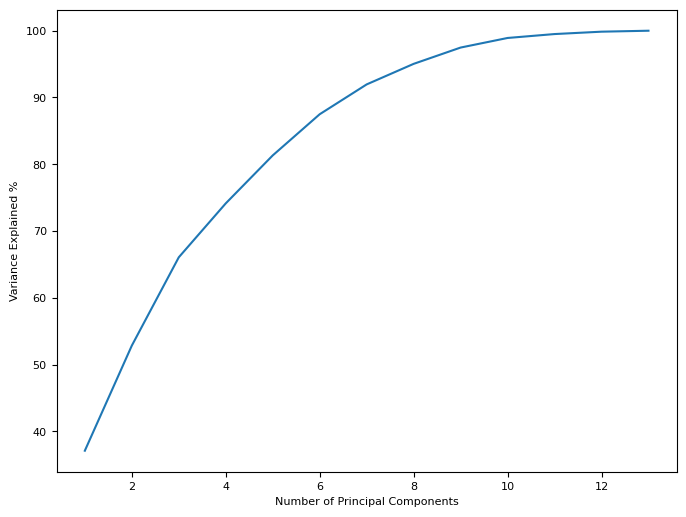

In [127]:
#how many PC ?
explained_variance = []

for n in range(1,len(features_test.columns)+1):
    pca = PCA(n_components=n)
    pca.fit(scaled_features)
    
    explained_variance.append(np.sum(pca.explained_variance_ratio_*100))

plt.plot(range(1,len(features_test.columns)+1),explained_variance)
plt.rcParams["figure.figsize"] = [8,6]
plt.xlabel("Number of Principal Components")
plt.ylabel("Variance Explained %");

if os.path.exists(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\PCA') == False:
    os.makedirs(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\PCA')

plt.savefig(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\PCA\\NumberPC',dpi=200)

print('Explained Variance % with 2 PC: ',explained_variance[1])
print('Explained Variance % with 3 PC: ', explained_variance[2])

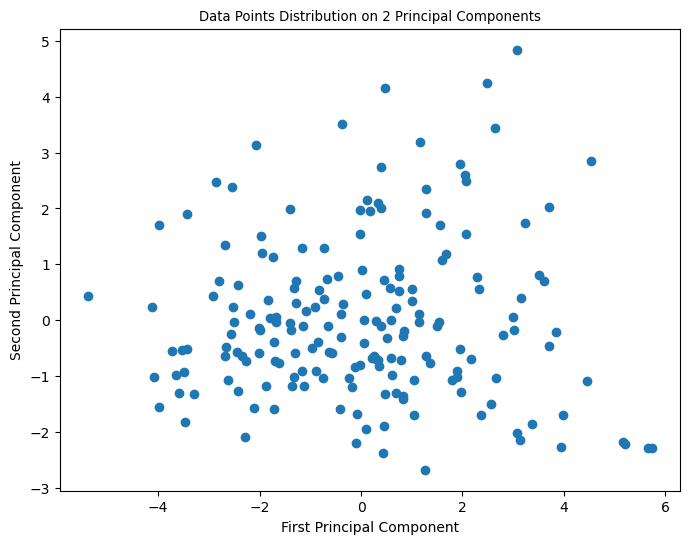

In [58]:
pca = PCA(n_components=2)
pc = pca.fit_transform(scaled_features)

fig, ax = plt.subplots()
scatter = ax.scatter(pc[:,0],pc[:,1])
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.rcParams.update({'font.size': 8})
plt.rcParams["figure.figsize"] = [8,6]
plt.title('Data Points Distribution on 2 Principal Components');


if os.path.exists(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\PCA') == False:
    os.makedirs(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\PCA')

plt.savefig(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\PCA\\DataPointsPCA',dpi=200)

### Kmean clustering

C:\Users\cbelb\anaconda3\envs\environment_1\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\cbelb\anaconda3\envs\environment_1\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\cbelb\anaconda3\envs\environment_1\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\cbelb\anaconda3\envs\environment_1\lib\site-packages\sklearn\cluster\_

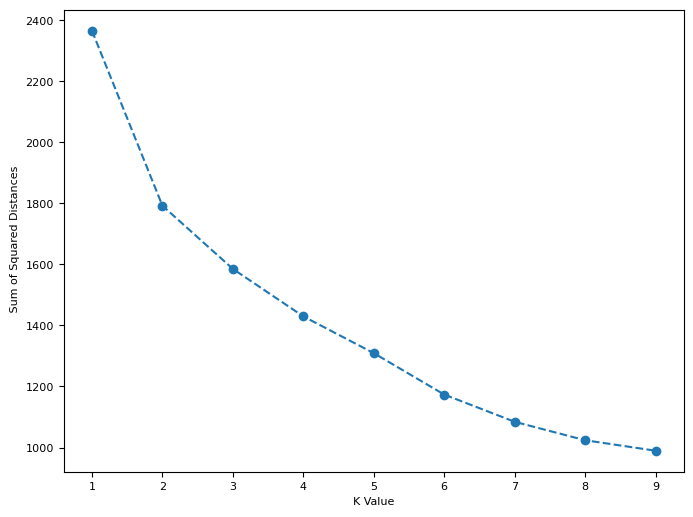

In [59]:
#K-mean cluster: understand the suitable number of clusters to be considered 

ssd = []
for k in range(1,10):
    model = KMeans(n_clusters=k)
    model.fit(scaled_features)
    
    #inertia_ = Sum of squared distances of samples to their closest cluster center.
    ssd.append(model.inertia_)

plt.plot(range(1,10),ssd,'o--')
plt.xlabel("K Value")
plt.ylabel(" Sum of Squared Distances");

if os.path.exists(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\Kmeans') == False:
    os.makedirs(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\Kmeans')

plt.savefig(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\Kmeans\Kselection',dpi=200)

In [128]:
np.random.seed(42)
model = KMeans(n_clusters=num_cl)
cluster_labels = model.fit_predict(scaled_features)
features_test['cluster'] = cluster_labels

C:\Users\cbelb\anaconda3\envs\environment_1\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


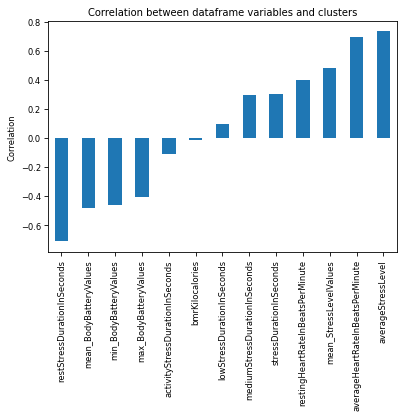

In [129]:
#to understand the which features are more important in the separation process
plt.figure(figsize=(6,4),dpi=75)
features_test.corr()['cluster'].iloc[:-1].sort_values().plot(kind='bar')
plt.ylabel('Correlation')
plt.rcParams.update({'font.size': 8})
plt.rcParams["figure.figsize"] = [6,15]
plt.title('Correlation between dataframe variables and clusters');

if os.path.exists(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\Kmeans\\' + str(num_cl)) == False:
    os.makedirs(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\Kmeans\\'+str(num_cl))

plt.savefig(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\Kmeans\\'+str(num_cl)+'\FeaturesCorrelation',dpi=200)

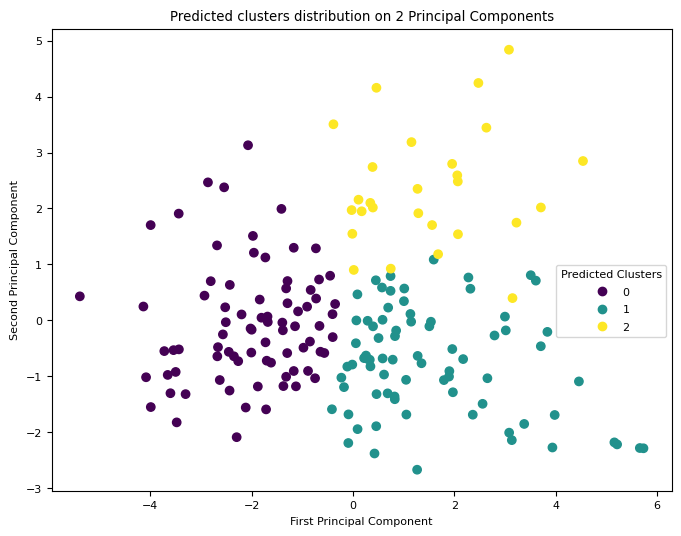

In [137]:
pca = PCA(n_components=2)
pc = pca.fit_transform(scaled_features)

fig, ax = plt.subplots()
scatter = ax.scatter(pc[:,0],pc[:,1],c=features_test['cluster'])
legend1 = ax.legend(*scatter.legend_elements(), title="Predicted Clusters",bbox_to_anchor=(1, 0.5))
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.rcParams.update({'font.size': 8})
plt.rcParams["figure.figsize"] = [8,6]
plt.title('Predicted clusters distribution on 2 Principal Components');

if os.path.exists(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\Kmeans\\' + str(num_cl)) == False:
    os.makedirs(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\Kmeans\\'+str(num_cl))

plt.savefig(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\Kmeans\\'+str(num_cl)+'\PCA_PredictedClusters',dpi=150)

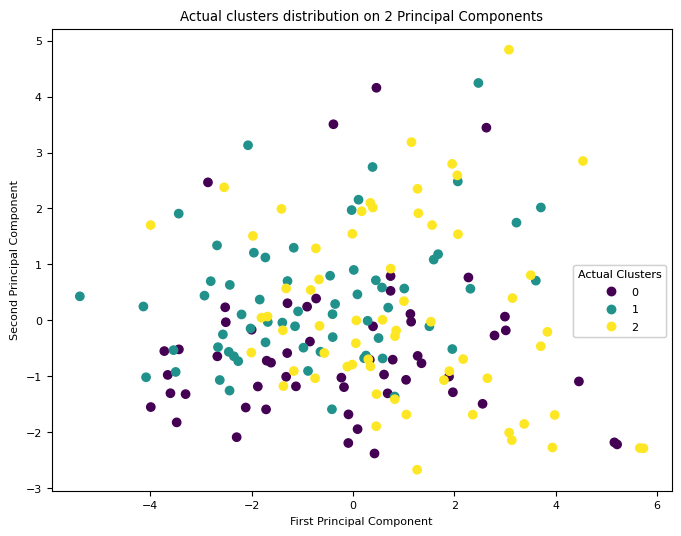

In [131]:

fig, ax = plt.subplots()
scatter = ax.scatter(pc[:,0],pc[:,1],c=features_actual['cluster'])
legend1 = ax.legend(*scatter.legend_elements(), title="Actual Clusters",bbox_to_anchor=(1, 0.5))
ax.add_artist(legend1)
plt.rcParams.update({'font.size': 8})
plt.rcParams["figure.figsize"] = [8,6]
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Actual clusters distribution on 2 Principal Components');

if os.path.exists(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\Kmeans\\' + str(num_cl)) == False:
    os.makedirs(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\Kmeans\\'+str(num_cl))

plt.savefig(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\Kmeans\\'+str(num_cl)+'\PCA_ActualCLusters',dpi=150)

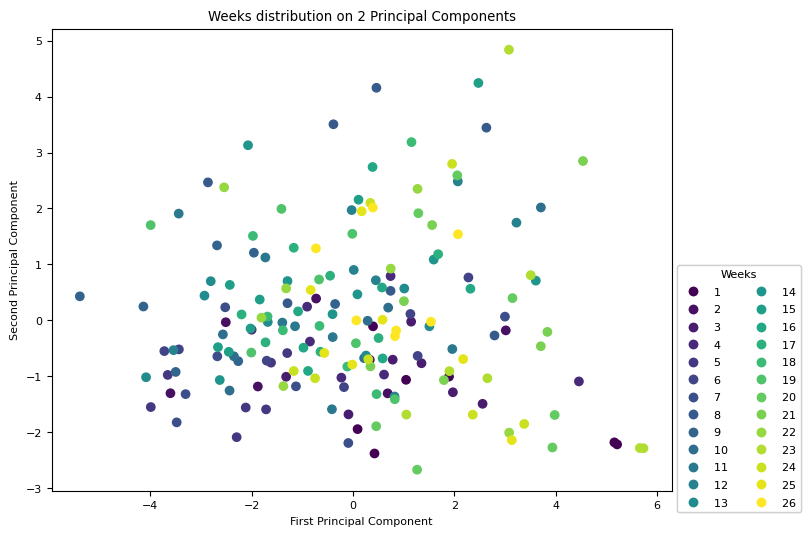

In [132]:
fig, ax = plt.subplots()
scatter = ax.scatter(pc[:,0],pc[:,1],c=weeks)
legend1 = ax.legend(*scatter.legend_elements(num=27), title="Weeks",bbox_to_anchor=(1, 0.5), ncol=2)
ax.add_artist(legend1)
plt.rcParams.update({'font.size': 8})
plt.rcParams["figure.figsize"] = [8,6]
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Weeks distribution on 2 Principal Components');

if os.path.exists(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\Kmeans\\' + str(num_cl)) == False:
    os.makedirs(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\Kmeans\\'+str(num_cl))

plt.savefig(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\Kmeans\\'+str(num_cl)+'\PCA_WeeksDistribution', dpi=200)

### Performance Metrics

Model accuracy =  0.31


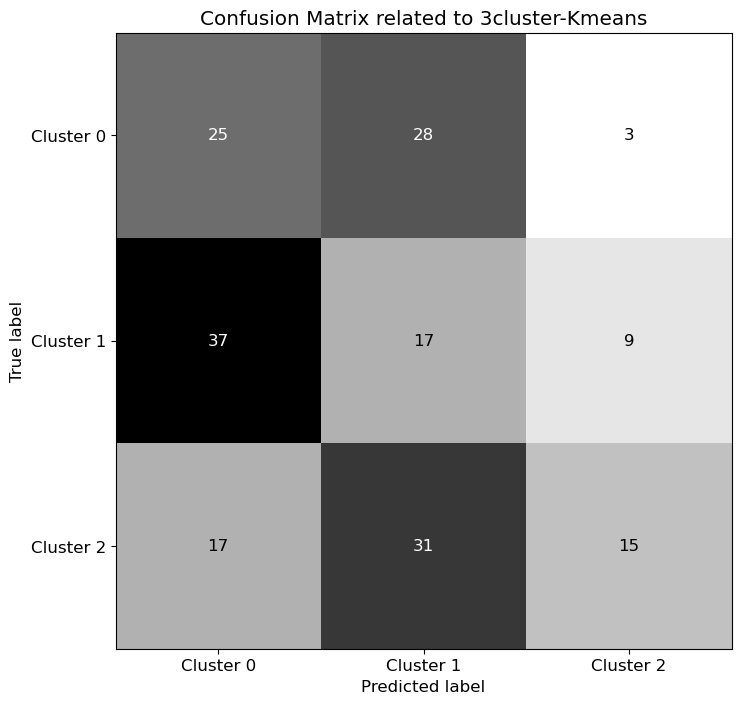

In [135]:
#confusion matrix
cmKM = metrics.confusion_matrix(features_actual['cluster'], features_test['cluster'])

if num_cl==3:
    cmKM_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cmKM, display_labels = ['Cluster 0','Cluster 1', 'Cluster 2'])
    cmKM_display.plot(cmap='Greys',colorbar=False)
    plt.rcParams.update({'font.size': 12})
    plt.rcParams["figure.figsize"] = [9,8]
    plt.title('Confusion Matrix related to 3cluster-Kmeans');
    plt.savefig(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\Kmeans\\'+str(num_cl)+'\ConfusionMatrix', dpi=200)
    
    report=classification_report(features_actual['cluster'], features_test['cluster'],output_dict=True, digits=2)
    report=pd.DataFrame(report).transpose().round(2)
    accuracy=report.iloc[3,0]
    report=report.iloc[:3,:].drop(columns='support')
    report['clusters']=['Cluster 0', 'Cluster 1', 'Cluster 2']

    report=report[['clusters','precision','recall','f1-score']]
    report.to_excel(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\Kmeans\\'+str(num_cl)+'\PerformanceMetrics.xlsx')
    
    print('Model accuracy = ', accuracy)
    
#     fig, ax = plt.subplots()

#     # hide axes
#     fig.patch.set_visible(False)
#     ax.axis('off')
#     ax.axis('tight')

#     t=ax.table(cellText=report.values, colLabels=report.columns, loc='center',rowLoc='center',colLoc='center',cellLoc='center')
#     t.auto_set_font_size(False)
#     t.set_fontsize(11)

#     fig.tight_layout()
#     plt.rcParams["figure.figsize"] = [6,6]
    

if num_cl==2:
    cmKM_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cmKM, display_labels = ['Cluster 0','Cluster 1'])
    cmKM_display.plot(cmap='Greys',colorbar=False)
    plt.rcParams.update({'font.size': 12})
    plt.rcParams["figure.figsize"] = [9,8]
    plt.title('Confusion Matrix related to 2cluster-Kmeans');
    plt.savefig(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\Kmeans\\'+str(num_cl)+'\ConfusionMatrix', dpi=200)
    
    report=classification_report(features_actual['cluster'], features_test['cluster'],output_dict=True, digits=2)
    report=pd.DataFrame(report).transpose().round(2)
    accuracy=report.iloc[2,0]
    report=report.iloc[:2,:].drop(columns='support')
    report['clusters']=['cluster 0', 'cluster 1']

    report=report[['clusters','precision','recall','f1-score']]
    report.to_excel(r'C:\Users\cbelb\Desktop\Tirocinio\PythonAnalysis\Data\\' + userID + '\Kmeans\\'+str(num_cl)+'\PerformanceMetrics.xlsx')
    
    print('Model accuracy = ', accuracy)
    
#     fig, ax = plt.subplots()

#     # hide axes
#     fig.patch.set_visible(False)
#     ax.axis('off')
#     ax.axis('tight')

#     t=ax.table(cellText=report.values, colLabels=report.columns, loc='center',rowLoc='center',colLoc='center',cellLoc='center')
#     t.auto_set_font_size(False)
#     t.set_fontsize(11)

#     fig.tight_layout()
#     plt.rcParams["figure.figsize"] = [6,6]
   